In [2]:
%pip install --upgrade pymupdf

Note: you may need to restart the kernel to use updated packages.


In [3]:
import fitz  # PyMuPDF
doc = fitz.open("ignore/hdfc_statement.pdf")
text = ""
for page in doc: 
    text += page.get_text()

In [5]:
import re

lines = text.splitlines()
txns = []
for i, line in enumerate(lines):
    if re.match(r'^\d{2}/\d{2}/\d{2}', line):
        # start of a transaction
        # Extract pieces assuming fixed columns (parsed manually or via substring)
        date = line[0:8].strip()
        val_date = line[40:48].strip()
        withdrawal = line[49:58].strip().replace(',', '')
        deposit = line[59:68].strip().replace(',', '')
        closing = line[69:].strip().replace(',', '')
        narration = ""  # accumulate narration parts from this and following lines
        # gather narration lines below the date line
        j = i+1
        while j < len(lines) and not re.match(r'^\d{2}/\d{2}/\d{2}', lines[j]):
            narration += " " + lines[j].strip()
            j += 1
        txns.append({
            "Date": date, "ValueDate": val_date,
            "Withdrawal": withdrawal or "0",
            "Deposit": deposit or "0",
            "ClosingBalance": closing,
            "Narration": narration.strip()
        })

In [7]:
import pandas as pd
df = pd.DataFrame(txns)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
# df['ValueDate'] = pd.to_datetime(df['ValueDate'], format='%d/%m/%y')
df['ValueDate'] = pd.to_datetime(df['ValueDate'], format='%d/%m/%y', errors='coerce')
df['Withdrawal'] = pd.to_numeric(df['Withdrawal'], errors='coerce').fillna(0)
df['Deposit'] = pd.to_numeric(df.get('Deposit','0'), errors='coerce').fillna(0)
df['ClosingBalance'] = pd.to_numeric(df['ClosingBalance'], errors='coerce')

In [10]:
# Check for missing values
print(df['ValueDate'].isna().sum())

# Option 1: Forward-fill missing dates
df['ValueDate'].fillna(method='ffill', inplace=True)

# Option 2: Drop rows with missing dates
df.dropna(subset=['ValueDate'], inplace=True)

0


In [11]:
df['ValueDate'] = pd.to_datetime(df['ValueDate'], format='%m/%d/%y', errors='coerce')

In [21]:
# df['ValueDate'] = df['ValueDate'].str.strip()
df['ValueDate'] = pd.to_datetime(df['ValueDate'], format='%d/%m/%y', errors='coerce')

In [22]:
df['ValueDate'] = df['ValueDate'].fillna(method='ffill')  # forward fill, for example

In [23]:
df['ValueDate'] = pd.to_datetime(df['ValueDate'], format='%d/%m/%y', errors='coerce')

In [25]:
CATEGORIES = {
    "Food": ["ZOMATO", "BHATS MILK", "SWEET", "CATERING"],
    "Fuel": ["PETROL", "PETROLEUM"],
    "Shopping": ["MARKETPLACE", "SHOP", "LAUNDRY"],
    "Bills": ["INSURANCE", "RENT", "BILLS"],
    # etc.
}

In [26]:
df['Category'] = "Misc"
for cat, keywords in CATEGORIES.items():
    pattern = "|".join([re.escape(k) for k in keywords])
    df.loc[df['Narration'].str.contains(pattern, case=False, na=False), 'Category'] = cat

In [27]:
daily = df.groupby('Date').agg(TotalDebit=('Withdrawal','sum'),
                               TotalCredit=('Deposit','sum'),
                               Count=('Date','size')).reset_index()

In [50]:
# Example: compute ending balance per day
df_sorted = df.sort_values('Date')
balance_by_day = df_sorted.groupby('Date').last()['ClosingBalance']
idx = pd.date_range(balance_by_day.index.min(), balance_by_day.index.max(), freq='D')
balance_daily = balance_by_day.reindex(idx).ffill()

In [39]:
import re

date_pattern = re.compile(r'\d{2}/\d{2}/\d{2,4}')  # date pattern (dd/mm/yy or dd/mm/yyyy)

txns = []
i = 0
while i < len(lines):
    if date_pattern.search(lines[i]):
        # Extract date from the current line
        date_match = date_pattern.search(lines[i])
        date = date_match.group()
        
        # Collect narration and amount lines until next date line
        narration_lines = []
        j = i + 1
        while j < len(lines) and not date_pattern.search(lines[j]):
            narration_lines.append(lines[j].strip())
            j += 1
        
        narration_text = " ".join(narration_lines)
        
        # Extract amounts from narration_text (numbers with commas and decimals)
        amounts = re.findall(r'[\d,]+\.\d{2}', narration_text)
        # Normalize amounts (remove commas)
        amounts = [amt.replace(',', '') for amt in amounts]
        
        # Assign amounts intelligently:
        # Heuristic: Usually Withdrawal, Deposit, Closing Balance appear in that order
        withdrawal = deposit = closing = '0'
        if len(amounts) == 3:
            withdrawal, deposit, closing = amounts
        elif len(amounts) == 2:
            withdrawal, deposit = amounts
        elif len(amounts) == 1:
            withdrawal = amounts[0]
        
        txns.append({
            "Date": date,
            "Narration": narration_text,
            "Withdrawal": withdrawal,
            "Deposit": deposit,
            "ClosingBalance": closing
        })
        
        i = j
    else:
        i += 1

print(f"Extracted {len(txns)} transactions")
print(txns[:3])  # sample output


Extracted 51 transactions
[{'Date': '02/09/25', 'Narration': 'UPI-ZEPTO MARKETPLACE PR-ZEPTOMARKETPLAC 0000110697582430', 'Withdrawal': '0', 'Deposit': '0', 'ClosingBalance': '0'}, {'Date': '02/09/25', 'Narration': '258.79 24,326.08 895229.RZP@RXAIRTEL-AIRP0000011-11069758 2430-ROOM FRESHNER', 'Withdrawal': '258.79', 'Deposit': '24326.08', 'ClosingBalance': '0'}, {'Date': '03/09/25', 'Narration': 'UPI-BHATS MILK AND MILK -PAYTMQR6BYKTD@P 0000110710453744', 'Withdrawal': '0', 'Deposit': '0', 'ClosingBalance': '0'}]


In [40]:
import pandas as pd

df = pd.DataFrame(txns)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce')
df['Withdrawal'] = pd.to_numeric(df['Withdrawal'], errors='coerce').fillna(0)
df['Deposit'] = pd.to_numeric(df['Deposit'], errors='coerce').fillna(0)
df['ClosingBalance'] = pd.to_numeric(df['ClosingBalance'], errors='coerce').fillna(0)

print(df.head())


        Date                                          Narration  Withdrawal  \
0 2025-09-02  UPI-ZEPTO MARKETPLACE PR-ZEPTOMARKETPLAC 00001...        0.00   
1 2025-09-02  258.79 24,326.08 895229.RZP@RXAIRTEL-AIRP00000...      258.79   
2 2025-09-03  UPI-BHATS MILK AND MILK -PAYTMQR6BYKTD@P 00001...        0.00   
3 2025-09-03  55.00 24,271.08 TYS-YESB0PTMUPI-110710453744-C...       55.00   
4 2025-09-03  UPI-ITSY BITSYYEOLEKAR M-Q15560839@YBL-Y 00001...        0.00   

    Deposit  ClosingBalance  
0      0.00               0  
1  24326.08               0  
2      0.00               0  
3  24271.08               0  
4      0.00               0  


In [41]:
df['Category'] = "Misc"
for cat, keywords in CATEGORIES.items():
    pattern = "|".join([re.escape(k) for k in keywords])
    df.loc[df['Narration'].str.contains(pattern, case=False, na=False), 'Category'] = cat

In [42]:
daily = df.groupby('Date').agg(TotalDebit=('Withdrawal','sum'),
                               TotalCredit=('Deposit','sum'),
                               Count=('Date','size')).reset_index()

In [43]:
# Example: compute ending balance per day
df_sorted = df.sort_values('Date')
balance_by_day = df_sorted.groupby('Date').last()['ClosingBalance']
idx = pd.date_range(balance_by_day.index.min(), balance_by_day.index.max(), freq='D')
balance_daily = balance_by_day.reindex(idx).ffill()

In [44]:
total_debits = df['Withdrawal'].sum()
total_credits = df['Deposit'].sum()

In [45]:
highest_tx = df.loc[df['Withdrawal'].idxmax()]
lowest_tx = df.loc[df['Withdrawal'].idxmin()]

In [46]:
avg_daily_spend = df.groupby('Date')['Withdrawal'].sum().mean()
total_spend = df['Withdrawal'].sum()
top_merchants = df['Narration'].str.extract(r'([A-Z ]{3,})')[0]  # crude extract of merchant name part
top_merchants = top_merchants.value_counts().head(5)

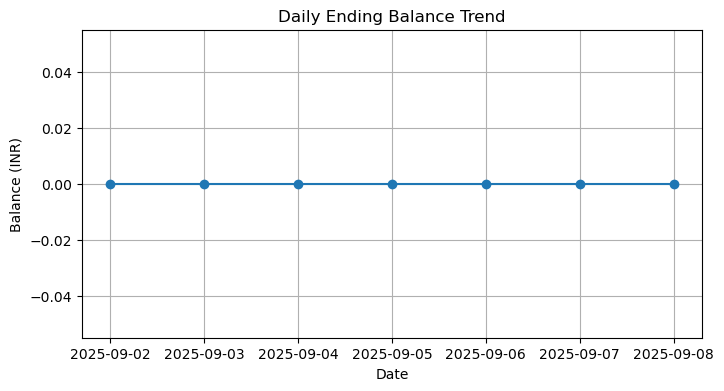

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(balance_daily.index, balance_daily.values, marker='o')
plt.title("Daily Ending Balance Trend")
plt.xlabel("Date"); plt.ylabel("Balance (INR)")
plt.grid(True)

Text(0.5, 1.0, 'Spending by Category')

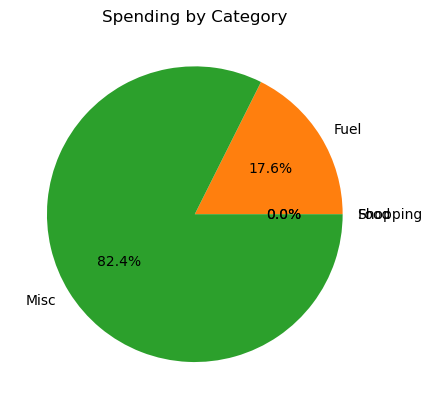

In [48]:
category_sums = df.groupby('Category')['Withdrawal'].sum()
fig, ax = plt.subplots()
ax.pie(category_sums.values, labels=category_sums.index, autopct='%1.1f%%')
ax.set_title("Spending by Category")

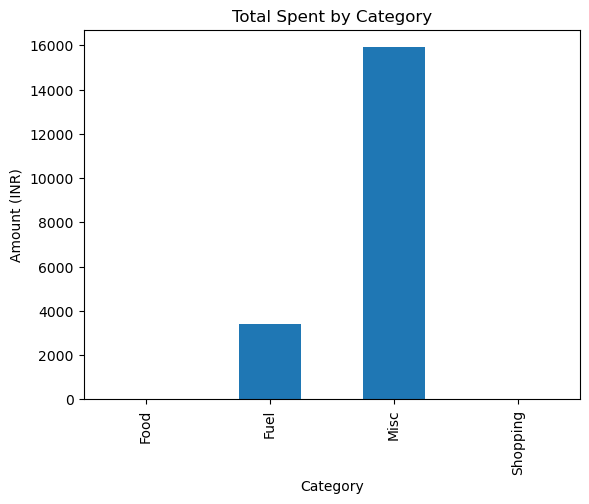

In [49]:
category_sums.plot(kind='bar', title="Total Spent by Category")
plt.xlabel("Category"); plt.ylabel("Amount (INR)");